# Setup

In [1]:
#%%writefile ../scripts/parallel_phi/phi_tpm_log_reg.py

import pyphi
import numpy as np
import itertools
import patsy
from sklearn.linear_model import LogisticRegression

In [2]:
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import binarize

In [3]:
import warnings
warnings.filterwarnings("ignore")
# UNCOMMENT ABOVE TO CHECK DEPRECATIONS

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
import pixiedust

Pixiedust database opened successfully


In [6]:
pyphi.config.PROGRESS_BARS = False

## Immutables

In [7]:
RAW_DATA_DIR = "../data/raw/"
SAMPLE_DATA_FILE = "split2250_bipolarRerefType1_lineNoiseRemoved_postPuffpreStim.mat"

In [8]:
FLY_DATA = sio.loadmat(RAW_DATA_DIR + SAMPLE_DATA_FILE).get("fly_data")

# Processing Functions

In [11]:
#%%writefile ../scripts/parallel_phi/phi_tpm_log_reg.py -a
def gen_log_reg(data, tau=1, interaction_order=0):
    """ Generate logistic regression for binarised past and present states.
    
    Args:
        data (array): (timepoints, channels, trials) array of binarised data.
                      The data will pool each timepoint step as a separate trial.
        tau (int): Time lag between present and next state.
        interaction_order (int): Order of interaction terms to be used.
                                 If 0, ALL interaction terms are included.
                                 If 1, NO interaction terms are included (i.e. all input order 1).
                                 If 2, interaction terms e.g. x1:x2 are included etc.
                      
    Returns: 
        List of Logistic regressions (fitted) for each channel.
    """
    
    n_timepoints, n_channels, n_trials = data.shape
    
    if interaction_order > n_channels:
        raise ValueError("Interaction order must not exceed number of channels.")
    
    presents = data[:n_timepoints - tau, :, :]\
                .transpose(2, 0, 1)\
                .reshape((n_trials * (n_timepoints - tau), n_channels))
    nexts = data[tau:, :, :]\
                .transpose(2, 0, 1)\
                .reshape((n_trials * (n_timepoints - tau), n_channels))
    
    # ----------------------------------------------------------------------------
    # FOR TESTING ONLY 
    # Once a "method" has been decided, the extraneous code can be removed.
    # ----------------------------------------------------------------------------
    
    x_vars = ["x{}".format(i_x) for i_x in range(n_channels)]
    
    if interaction_order == 0:
        data_dict = {"x{}".format(i_x): presents[:, i_x] for \
                    i_x in range(n_channels)}

        patsy_str = "*".join(x_vars)

        X_dmatrix = patsy.dmatrix(patsy_str, data_dict)
        Xs = X_dmatrix[:, 1:] # exclude intercept term
    elif interaction_order == 1:
        Xs = presents
    else:
        data_dict = {"x{}".format(i_x): presents[:, i_x] for \
            i_x in range(n_channels)}
        patsy_str = " + ".join(x_vars)
        for i_o in range(2, interaction_order + 1):
            combinations = itertools.combinations(x_vars, i_o)
            comb_strs = map(":".join, combinations)
            patsy_str += " + " + " + ".join(comb_strs)
            X_dmatrix = patsy.dmatrix(patsy_str, data_dict)
            Xs = X_dmatrix[:, 1:] # exclude intercept term
    
    # ----------------------------------------------------------------------------
    
    models = []
    
    for i_c in range(n_channels):
        y = nexts[:, i_c]
        lr = LogisticRegression(solver='lbfgs')
        model = lr.fit(Xs, y)
        models.append(model)
    
    return models

In [13]:
#%%writefile ../scripts/parallel_phi/phi_tpm_log_reg.py -a
def models_to_tpm(models, n_channels, interaction_order=0):
    """ Converts a logistic regression model to a TPM
    
    Args:
        models: List of fitted logistic regression models.
        n_channels (int): Number of channels used to generate model.
        interaction_order (int): Order of interaction terms used to define model.
        
    Returns:
        A numpy array as a TPM.
    """
    
    tpm_shape = [2] * n_channels + [n_channels]
    
    tpm = np.zeros(tpm_shape)
    
    for state in itertools.product((0, 1), repeat=n_channels):
        for i_m, model in enumerate(models):
            state_arr = np.array(state)
            
            # ----------------------------------------------------------------------------
            # FOR TESTING ONLY 
            # Once a "method" has been decided, extraneous code can be removed.
            # ----------------------------------------------------------------------------
            x_vars = ["x{}".format(i_x) for i_x in range(n_channels)]
            
            if interaction_order == 0:
                data_dict = {"x{}".format(i_x): state_arr[i_x] for \
                            i_x in range(n_channels)}
                patsy_str = "*".join(x_vars)
                state_dmatrix = patsy.dmatrix(patsy_str, data_dict)
                state_all = state_dmatrix[:, 1:]
            elif interaction_order == 1:
                state_all = state_arr.reshape(1, -1)
            else:
                data_dict = {"x{}".format(i_x): state_arr[i_x] for \
                    i_x in range(n_channels)}
                patsy_str = " + ".join(x_vars)
                for i_o in range(2, interaction_order + 1):
                    combinations = itertools.combinations(x_vars, i_o)
                    comb_strs = map(":".join, combinations)
                    patsy_str += " + " + " + ".join(comb_strs)
                    state_dmatrix = patsy.dmatrix(patsy_str, data_dict)
                    state_all = state_dmatrix[:, 1:] # exclude intercept term
            tpm[state + (i_m,)] = model.predict_proba(state_all)[0][1]
            # ----------------------------------------------------------------------------
    
    return tpm

In [15]:
#%%writefile ../scripts/parallel_phi/phi_tpm_log_reg.py -a
def tpm_log_reg(data, tau=1, interaction_order=0):
    """ Generate tpm using log regression for binarised past and present states.
    
    Args:
        data (array): (timepoints, channels, trials) array of binarised data.
                      The data will pool each timepoint step as a separate trial.
                      Will also accept (timepoints, channels) 2D array.
                      
    Returns: 
        TPM for the input data.
    """
    
    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=-1) # adds trial axis, 1 "trial"
    
    n_timepoints, n_channels, n_trials = data.shape
    
    models = gen_log_reg(data, tau, interaction_order)
    
    tpm = models_to_tpm(models, n_channels, interaction_order)
    
    state_counter = np.zeros(2 ** n_channels)
    
    pooled = data.transpose(2, 0, 1).reshape(n_timepoints * n_trials, n_channels)
    
    for i_s in range(2 ** n_channels):
        state = pyphi.convert.le_index2state(i_s, n_channels)
        state_count = (pooled == np.array(state)).all(axis=-1).sum()
        state_counter[i_s] = state_count
    
    return pyphi.convert.to_2dimensional(tpm), state_counter

# Testing

## Generated Data (Deterministic)

In [16]:
def det_generate(tpm, n_timepoints, n_channels, n_trials):
    
    states = list(itertools.product((0, 1), repeat=n_channels))
    
    samples = np.zeros((1 + n_timepoints, n_channels, (2 ** n_channels) * n_trials))
    
    for i_s, state in enumerate(states * n_trials):
        samples[0, :, i_s] = np.array(state)
        
        for i_t in range(n_timepoints):
            curr_state = tuple(samples[i_t, :, i_s].astype(int))
            value = tpm[curr_state]
            samples[i_t + 1, :, i_s] = value
    
    return samples

In [17]:
test_shape = [2] * 3 + [3]
test_tpm = np.zeros(test_shape)

test_tpm[(0, 0, 0)] = np.array([0, 0, 0])
test_tpm[(1, 0, 0)] = np.array([0, 0, 1])
test_tpm[(0, 1, 0)] = np.array([1, 0, 1])
test_tpm[(1, 1, 0)] = np.array([1, 0, 0])
test_tpm[(0, 0, 1)] = np.array([1, 1, 0])
test_tpm[(1, 0, 1)] = np.array([1, 1, 1])
test_tpm[(0, 1, 1)] = np.array([1, 1, 1])
test_tpm[(1, 1, 1)] = np.array([1, 1, 0])

In [18]:
network_tpm_in = pyphi.Network(test_tpm)

In [19]:
test_state = (1, 0, 0)

In [20]:
subsystem_in = pyphi.Subsystem(network_tpm_in, test_state)

In [21]:
pyphi.compute.phi(subsystem_in)

2.3125

### 10 Trials

In [22]:
test_samples_10_trials = det_generate(test_tpm, 100, 3, 10)

In [23]:
out_tpm_10_trials, state_counter_10_trials = tpm_log_reg(test_samples_10_trials, interaction_order=0)
out_tpm_10_trials = out_tpm_10_trials.round(decimals=1)

In [24]:
for i_state in range(2 ** 3):
    state = pyphi.convert.le_index2state(i_state, 3)
    print("STATE = {}, IN_TPM = {}, OUT_TPM = {}".format(state, 
                                                         test_tpm[state], 
                                                         out_tpm_10_trials[i_state]))

STATE = (0, 0, 0), IN_TPM = [0. 0. 0.], OUT_TPM = [0. 0. 0.]
STATE = (1, 0, 0), IN_TPM = [0. 0. 1.], OUT_TPM = [0. 0. 1.]
STATE = (0, 1, 0), IN_TPM = [1. 0. 1.], OUT_TPM = [0.9 0.  0.1]
STATE = (1, 1, 0), IN_TPM = [1. 0. 0.], OUT_TPM = [1. 0. 0.]
STATE = (0, 0, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]
STATE = (1, 0, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1. 1. 1.]
STATE = (0, 1, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1.  1.  0.5]
STATE = (1, 1, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]


In [25]:
network_tpm_out_10 = pyphi.Network(out_tpm_10_trials)

In [26]:
subsystem_out_10 = pyphi.Subsystem(network_tpm_out_10, test_state)

In [27]:
pyphi.compute.phi(subsystem_out_10)

0.881276

In [28]:
print(state_counter_10_trials)

[1010. 2330.   10. 2340. 2320.   20.   10.   40.]


### 100 Trials

In [29]:
test_samples_100_trials = det_generate(test_tpm, 100, 3, 100)

In [30]:
out_tpm_100_trials, state_counter_100_trials = tpm_log_reg(test_samples_100_trials, tau=1, interaction_order=0)
out_tpm_100_trials = out_tpm_100_trials.round(decimals=1)

In [31]:
for i_state in range(2 ** 3):
    state = pyphi.convert.le_index2state(i_state, 3)
    print("STATE = {}, IN_TPM = {}, OUT_TPM = {}".format(state, 
                                                         test_tpm[state], 
                                                         out_tpm_100_trials[i_state]))

STATE = (0, 0, 0), IN_TPM = [0. 0. 0.], OUT_TPM = [0. 0. 0.]
STATE = (1, 0, 0), IN_TPM = [0. 0. 1.], OUT_TPM = [0. 0. 1.]
STATE = (0, 1, 0), IN_TPM = [1. 0. 1.], OUT_TPM = [1.  0.  0.8]
STATE = (1, 1, 0), IN_TPM = [1. 0. 0.], OUT_TPM = [1. 0. 0.]
STATE = (0, 0, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]
STATE = (1, 0, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1. 1. 1.]
STATE = (0, 1, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1.  1.  0.9]
STATE = (1, 1, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]


> As a note, it seems when the number of trials is low and a certain state does not occur frequently, the transition probability from that state is quite poorly estimated (as can be seen from the comparison from 10 trials and 50 trials above). 

In [32]:
network_tpm_out_100 = pyphi.Network(out_tpm_100_trials)

In [33]:
subsystem_out_100 = pyphi.Subsystem(network_tpm_out_100, test_state)

In [34]:
pyphi.compute.phi(subsystem_out_100)

1.779672

In [35]:
print(state_counter_100_trials)

[10100. 23300.   100. 23400. 23200.   200.   100.   400.]


## Fly Data

In [9]:
FLY_DATA.shape

(2250, 15, 8, 13, 2)

The shape of the data corresponds to:

- 2250 time samples (at 1000Hz)
- 15 channels (bipolar re-referenced)
- 8 "trials" (from one trial cut into smaller trials)
- 13 flies
- 2 conditions (awake and anaesthetised respectively)

The reference paper is at https://doi.org/10.1523/ENEURO.0329-17.2018

In [10]:
n_samples, n_channels, n_trials, n_flies, n_conds = FLY_DATA.shape

This is already roughly in the shape we need it to be (except the last two dimensions, which we can loop over).

### Binarisation

Let's binarise using the median per channel, per fly.

In [12]:
meds = np.array([[np.median(FLY_DATA[:, c, :, f, :]) for c in range(n_channels)] for f in range(n_flies)])

In [13]:
meds.shape

(13, 15)

So our `meds` array is a (fly, channel) array of medians.

We can then binarise our `FLY_DATA` separately for each median.

In [14]:
data_binarised_list = [[np.where(FLY_DATA[:, c, :, f, :] > meds[f, c], 1, 0) for c in range(n_channels)] for f in range(n_flies)]

And now we restack the data matrices back to our original shape.

In [15]:
data_binarised = np.stack(map(lambda x: np.stack(x, axis=1), data_binarised_list), axis=3)

In [16]:
data_binarised.shape

(2250, 15, 8, 13, 2)

Now we can visualise the binarised data for all trials, all channels, and all flies for a single condition.

Each subplot shows time on the x-axis and the channel on the y-axis. The "whole-plot x-axis" represents trials and the "whole-plot y-axis" represents different flies. 

So for condition 0, we can see:

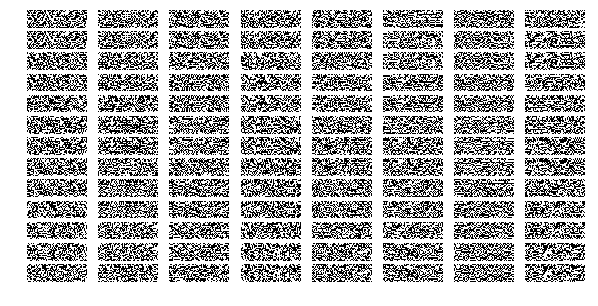

In [71]:
for i in range(n_trials * n_flies):
    subplot_tuple = (n_flies, n_trials, i+1)
    i_fly = i // n_flies
    i_trial = i % n_trials
    plt.subplot(*subplot_tuple)
    plt.imshow(data_binarised[:, :, i_fly, i_trial, 0].transpose(), aspect='auto', cmap='binary')
    plt.axis("off")

And for condition 1:

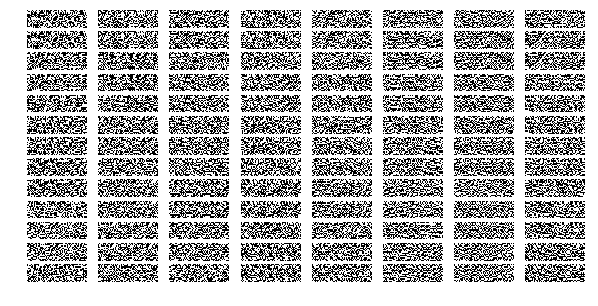

In [72]:
for i in range(n_trials * n_flies):
    subplot_tuple = (n_flies, n_trials, i+1)
    i_fly = i // n_flies
    i_trial = i % n_trials
    plt.subplot(*subplot_tuple)
    plt.imshow(data_binarised[:, :, i_fly, i_trial, 1].transpose(), aspect='auto', cmap='binary')
    plt.axis("off")

And just to check if there's a difference between the mean value for each condition:

In [74]:
print(np.mean(data_binarised[:, :, :, :, 0]))
print(np.mean(data_binarised[:, :, :, :, 1]))

0.4979777777777778
0.5020222222222223


Let's also save the binarised data.

In [20]:
data_binarised_file = "../data/processed/fly_data_binarised"

# SAVE DATA
#np.save(data_binarised_file, data_binarised)

# LOAD DATA
data_binarised = np.load(data_binarised_file + ".npy")

In [22]:
data_binarised.shape

(2250, 15, 8, 13, 2)

### Creating a Networks (Channel Set) File

In [135]:
kwargs = {}
kwargs["interaction_order"] = 0

In [139]:
if kwargs.get("interaction_ordefr") == None:
    print("NO INTERACTION ORDER")

NO INTERACTION ORDER


In [131]:
def create_network_file(n_channels, n_test_channels):
    combinations = itertools.combinations(range(n_channels), n_test_channels)
    filename = "../scripts/parallel_phi/networks_{}ch".format(n_test_channels)
    with open(filename, "w+") as outfile:
        for i_c, combo in enumerate(combinations):
            outfile.write("{},{}\n".format(i_c, ",".join(map(str, combo))))

In [132]:
for i in range(2, 5):
    create_network_file(n_channels, i)

### Calculating $\Phi$

> NB: This was moved to a script for execution in a parallel environment. The below may be out of date.

Let's loop through the data and calculate a per-trial, per-fly, per-condition $\Phi$ value.

We want to try TPM generation by several methods:

1. Directly calculating from the data (i.e. specifying a time lag and the subsequent transition from each raw state)
2. Using logistic regression without any interaction terms
3. Using logistic regression with interaction terms of an order up to the number of channels included. 

And we would like to repeat this for 2-channel, 3-channel and 4-channel $\Phi$. 

We've already defined our logistic regression TPM functions - let's also load a TPM building function that directly works from the data written by Angus Leung.

In [80]:
%run ../scripts/parallel_phi/phi_functions.py

In [82]:
help(build_tpm_sbn)

Help on function build_tpm_sbn in module __main__:

build_tpm_sbn(data, tau, n_values)
    Builds a state-by-node TPM, holding the probabilities of each node being "on" given some past
    network states
    
    http://pyphi.readthedocs.io/en/stable/conventions.html?highlight=state%20by%20node
    
    Inputs:
            fly_data = matrix (of discretised data) with dimensions (samples x channels)
                    Holds data across which TPM should be built
            tau = integer - the lag between current and future states
                    e.g. 1 means that the current and future sample are adjacent
                    e.g. 2 means that there is one sample between the current and future samples, etc.
            n_values = number of states each *node* can be in (e.g. 2 for ON and OFF)
    Outputs:
            tpm = matrix with dimensions (n_values^channels x channels)
                    Each row holds the probabilities of each channel being "on" in the future, given a past
 

Okay! Let's write a calculation function now.

In [109]:
def calculate_phis(data, n_test_channels, method, **kwargs):
    """ Calculates and saves phi values for a given number of test_channels for a given method.
    
    Args:
        data (np.ndarray): (samples, channels, trials, flies, conds) array of BINARISED data.
        n_test_channels (int): Number of channels to consider at a time. Minimum 2.
        method (string): Method used to generate TPM. 
                         Must be one of:
                         - "direct"
                         - "logistic" (requires kwarg interaction_order)
    
    Keyword Args:
        interaction_order (int): Parameter used for logistic method for TPM calculation.
    
    Returns:
        Nothing. 
        Instead, saves lists of dictionaries (per channel group) as .mat files with keys:
            i_trial
            i_fly
            i_cond
            state_phis
            tpm
            state_counts
            channels
    
    """
    
    n_samples, n_channels, n_trials, n_flies, n_conds = FLY_DATA.shape
    
    tau = 1
    
    results_dir = "../data/processed/phis/"
    
    ch_groups = itertools.combinations(range(n_channels), n_test_channels)
    
    if method == "direct":
        method_str = method
    elif method == "logistic":
        interaction_order = kwargs.get("interaction_order")
        if not interaction_order:
            raise ValueError("Must specify interaction_order if using logistic method.") 
        method_str = method + str(interaction_order)
    else:
        raise ValueError("Method specified was not recognised")
    
    # This deeply nested loop will take a long time...
    for ch_group in ch_groups:
        ch_group_results = []
        data_slice = data[:, ch_group, :, :, :]
        for cond in range(n_conds):
            #print("CONDITION {}".format(cond))
            for fly in range(n_flies):
                #print("  FLY {}".format(fly))
                for trial in range(n_trials):
                    #print("    TRIAL {}".format(trial))
                    if method == "direct":
                        tpm, state_counts = build_tpm_sbn(data_slice[:, :, trial, fly, cond], tau, 2)
                    else:
                        tpm, state_counts = tpm_log_reg(data_slice[:, :, trial, fly, cond], tau, interaction_order)
                    
                    n_states = n_test_channels ** 2
                    
                    network = pyphi.Network(tpm)
                    phi = dict()
                    state_sias = np.empty((n_states), dtype=object)
                    state_phis = np.zeros((n_states))
                    for state_index in range(n_states):
                        state = pyphi.convert.le_index2state(state_index, n_test_channels)
                        subsystem = pyphi.Subsystem(network, state)
                        #sia = pyphi.compute.sia(subsystem)
                        phi_val = pyphi.compute.phi(subsystem)
                        state_phis[state_index] = phi_val
                        #print('      STATE {}, PHI = {}'.format(state, phi_val))

                    # Store only phi values for each state
                    #phi['sias'] = state_sias
                    phi['state_phis'] = state_phis
                    phi['tpm'] = tpm
                    phi['state_counts'] = state_counts
                    phi['i_trial'] = trial
                    phi['i_fly'] = fly
                    phi['i_cond'] = cond
                    phi['channels'] = ch_group
                    
                    ch_group_results.append(phi)


        results_file = "PHI_{}_METHOD_{}_CHS_{}.mat".format(n_test_channels,
                                                            method_str,
                                                            "-".join(map(str, ch_group)))

        sio.savemat(results_dir + results_file, {'ch_group_results': ch_group_results}, do_compression=True, long_field_names=True)
        print('      SAVED {}\n'.format(results_dir + results_file))

Now we can run this for different parameters and time them.

#### 2-Channel $\Phi$

In [ ]:
%%time
calculate_phis(data_binarised, 2, "direct")

In [ ]:
%%time
calculate_phis(data_binarised, 2, "logistic", interaction_order=1)

In [ ]:
%%time
calculate_phis(data_binarised, 2, "logistic", interaction_order=0)

#### 3-Channel $\Phi$

In [ ]:
%%time
calculate_phis(data_binarised, 3, "direct")

In [ ]:
%%time
calculate_phis(data_binarised, 3, "logistic", interaction_order=1)

In [ ]:
%%time
calculate_phis(data_binarised, 3, "logistic", interaction_order=2)

In [ ]:
%%time
calculate_phis(data_binarised, 3, "logistic", interaction_order=0)

#### 4-Channel $\Phi$

In [ ]:
%%time
calculate_phis(data_binarised, 4, "direct")

In [ ]:
%%time
calculate_phis(data_binarised, 4, "logistic", interaction_order=1)

In [ ]:
%%time
calculate_phis(data_binarised, 4, "logistic", interaction_order=2)

In [ ]:
%%time
calculate_phis(data_binarised, 4, "logistic", interaction_order=3)

In [ ]:
%%time
calculate_phis(data_binarised, 4, "logistic", interaction_order=0)

### Decoding

#### Reading the Processed Data

Let's examine one channel group's data.

In [172]:
test_ch_group = sio.loadmat('../data/processed/phis/PHI_2_METHOD_direct_CHS_0-1.mat')

In [173]:
test_ch_group_results = test_ch_group["ch_group_results"]

In [174]:
test_ch_group_results.shape

(1, 208)

The results can then be indexed by something of the form:
    
```
test_ch_group_results[0, i_result]
```

In [175]:
test_ch_group_results[0, 0].shape

(1, 1)

We can then unbox this with
```
test_ch_group_results[0, i_result][0, 0]
```

In [176]:
test_ch_group_results[0, 0][0, 0]

(array([[0.001286, 0.001372, 0.001118, 0.000137]]), array([[0.47453704, 0.41898148],
       [0.58974359, 0.37321937],
       [0.4811784 , 0.58919804],
       [0.58134921, 0.62103175]]), array([[432.],
       [702.],
       [611.],
       [504.]]), array([[0]]), array([[0]]), array([[0]]), array([[0, 1]]))

To get the keys:

In [177]:
test_ch_group_results[0, 0].dtype

dtype([('state_phis', 'O'), ('tpm', 'O'), ('state_counts', 'O'), ('i_trial', 'O'), ('i_fly', 'O'), ('i_cond', 'O'), ('channels', 'O')])

And therefore to read a field, we can use:
```
test_ch_group_results[0, i_result][0, 0][field][0]
```

In [178]:
test_ch_group_results[0, 0][0, 0]["tpm"]

array([[0.47453704, 0.41898148],
       [0.58974359, 0.37321937],
       [0.4811784 , 0.58919804],
       [0.58134921, 0.62103175]])

We will need to unbox some of these as everything is stored as a 2D array.

In [179]:
test_ch_group_results[0, 0][0, 0]["i_fly"][0, 0]

0

In [180]:
test_ch_group_results[0, 0][0, 0]["state_phis"][0]

array([0.001286, 0.001372, 0.001118, 0.000137])

Let's write a function to get out values from this rather complicate data structure. 

It may be faster to just directly index when necessary, but this will help us remember how to properly unbox our values.

In [103]:
def extract_value(data, i_result, field):
    """ Extracts a value from the ch_group_results data structure.
    
    Args:
        data: The processed data structure from sio.loadmat[data_field]
        i_result: The index of the result in the data structure.
        field: A string, which must be one of:
            - "state_phis"
            - "tpm"
            - "state_counts"
            - "i_trial"
            - "i_fly"
            - "i_cond"
            - "channels"
            - "all"
    
    Returns:
        A np.ndarray of the extracted data.
    
    """
    
    if field == "state_phis" or field == "state_counts" or field == "channels":
        return data[0, i_result][0, 0][field][0]
    elif field == "i_trial" or field == "i_cond" or field == "i_fly":
        return data[0, i_result][0, 0][field][0, 0]
    elif field == "tpm":
        return data[0, i_result][0, 0][field]
    elif field == "all":
        return data[0, i_result][0, 0]
    else:
        raise ValueError("Field not recognised in input data.")